In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
# from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *
from sphMath.reference.sod import plotSod

In [2]:
from sphMath.kernels import getKernelEnum

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 800
dim = 1
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4, 1)
CFL = 0.3

gamma = 5/3
initialStateLeft = sodInitialState(1, 1, 0)
initialStateRight = sodInitialState(0.1795, 0.25, 0)
ratio = 4
smoothIC = False
timeLimit = 0.15

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.MonaghanScheme

domain = buildDomainDescription(l = 2, dim = 1, periodic = True, device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)
particleSystem = generateSod1D(nx, ratio, initialStateLeft, initialStateRight, gamma, solverConfig['kernel'], targetNeighbors, dtype, device, smoothIC, SimulationSystem)

dt = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)
timesteps = int(timeLimit / dt)

True: dxs: [tensor(0.0012, device='cuda:0')], ns: [tensor(800, device='cuda:0', dtype=torch.int32)], nx: 800
True: dxs: [tensor(0.0050, device='cuda:0')], ns: [tensor(200, device='cuda:0', dtype=torch.int32)], nx: 200
Key adaptiveHThreshold not found in config["support"]. Setting adaptiveHThreshold to 0.001


In [4]:
# solverConfig['regions'] = []
# solverConfig['supportScheme'] = 'Owen'
# solverConfig['adaptiveHThreshold'] = 1e-3
# solverConfig['support'] = {'iterations': 1, 'adaptiveHThreshold': 1e-3, 'scheme': 'Owen', 'targetNeighbors': targetNeighbors}

In [5]:
# solverConfig['support']['scheme'] = 'Owen'
# solverConfig['regions'] = []

In [6]:
# display(solverConfig)
# solverConfig['diffusion']['thermalConductivity'] = 0.0

In [7]:
# solverConfig['diffusion']['thermalConductivity'] = 0.5

In [8]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None


for i in (tq:=tqdm(range(timesteps))):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep, verbose = False)
    # simulationState.priorStep = [updates[-1], currentState[-1]]
    simulationState.priorStep = None
    
    states.append(copy.deepcopy(simulationState))

    kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
    thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
    totalEnergy = kineticEnergy + thermalEnergy

    tq.set_postfix({
        'Kinetic Energy': kineticEnergy.item(),
        'Thermal Energy': thermalEnergy.item(),
        'Total Energy': totalEnergy.item(),
        'Time': simulationState.t.item()
    })


  0%|          | 0/595 [00:00<?, ?it/s]

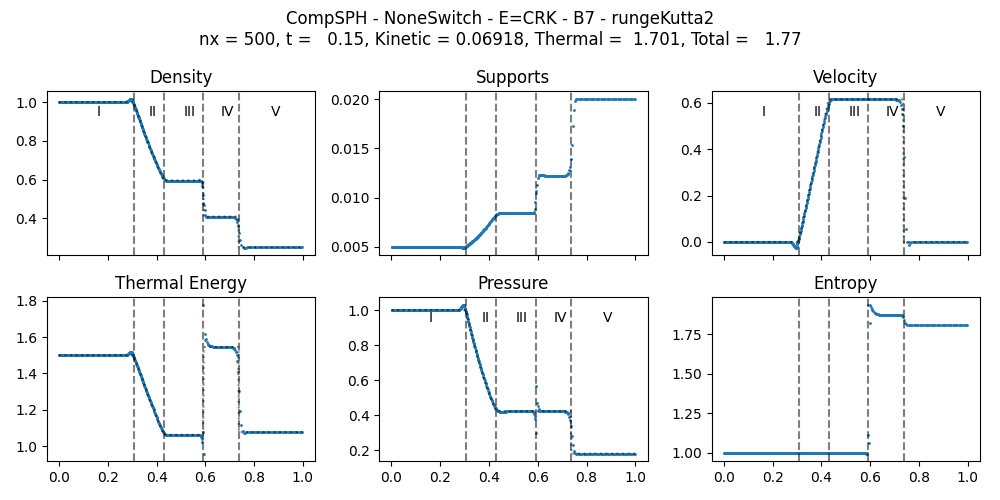

In [9]:
plotSod(states[-1], solverConfig, states[0].domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [11]:

from torch.profiler import profile, record_function, ProfilerActivity
profiledSystem = copy.deepcopy(simulationState)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    profiledSystem, currentState, updates = integrator.function(profiledSystem, dt, simulator, solverConfig, priorStep = profiledSystem.priorStep, verbose = False)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=15))

prof.export_chrome_trace("profile.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         [Integration] Symplectic Euler         0.06%      36.184us        99.89%      62.157ms      62.157ms       0.000us         0.00%       5.847ms       5.847ms             1  
                              [Integration] Update Step         0.72%     447.417us        87.77%      54.613ms      27.307ms       0.000us         0.00%       5.294ms       2.647ms             2  
         